# Language Audio Classification
For my second assessment in Machine Learning

In [1]:
#audio imports
import librosa
import numpy as np 
import pandas as pd 
import seaborn as sns
import os
import sys

from IPython.display import Audio
import matplotlib.pyplot as plt

import noisereduce as nr

target_sr = 32000 

## Creating Dataset
This is a function created to load a dataset of audio files into a pandas DataFrame / csv.

In [2]:
def load_dataset_to_csv(filepath):
    dataset = pd.DataFrame()

    lang_len = len(os.listdir(filepath))
    for lang_index, lang in enumerate(os.listdir(filepath)):

        audio_len = len(os.listdir(f'{filepath}/{lang}'))
        for audio_index, audio_file in enumerate(os.listdir(f'{filepath}/{lang}')):
            
            print(f'{lang_index + 1}/{lang_len} | {lang} | {audio_index + 1}/{audio_len}')
            
            audio_lb, sr = librosa.load(f'{filepath}/{lang}/{audio_file}', mono = True, duration = 15)

            insert = {
                "audio": [audio_lb],
                "sr": [sr],
                "label": [lang]
            }
            
            dataset = pd.concat([dataset, pd.DataFrame(insert)])
    
    return dataset

### Loading Dev Set 
Testing importation of data using a smaller dev set in order to check functionality.

In [ ]:
data_dev_set_path = "data_dev_set"
data_dev_set = load_dataset_to_csv(data_dev_set_path)

In [ ]:
data_dev_set

## Data Preprocessing
This function takes an audio waveform imported from librosa and preprocesses it via resampling, normalization, and cleanup. The accuracy of the model seems to increase when forgoing noise reduction and augmentation. This should be further explored in the future to increase model accuracy.

In [2]:
def preprocess_audio(audio, current_sr, target_sr):
    
    audio = resample(audio, current_sr, target_sr)

    audio = normalization(audio)

    audio = audio_cleaning(audio, target_sr)
    
    return audio

def resample(audio_data, orig_sr, target_sr):
    audio_data = librosa.resample(y = audio_data, orig_sr = orig_sr, target_sr = target_sr)
    return audio_data

def normalization(audio_data):
    #zero centering and normalizaton
    audio_data = audio_data - audio_data.mean() #zero centering
    audio_data = audio_data / audio_data.std() #normalization
    return audio_data

def audio_cleaning(audio_data, target_sr):
    #audio_data = nr.reduce_noise(y = audio_data, sr = target_sr) #noise reduction
    audio_data, _ = librosa.effects.trim(audio_data)
    return audio_data

#augmentation
def audio_augmentation(audio_data, target_sr):
    audio_data = librosa.effects.time_stretch(audio_data, rate=1.2)
    audio_data = librosa.effects.pitch_shift(audio_data, sr=target_sr, n_steps=2)

    speed_factor = np.random.uniform(0.7, 1.3)
    audio_data = librosa.effects.time_stretch(audio_data, rate=speed_factor)

    audio_data = librosa.effects.preemphasis(audio_data, coef=0.97)

    return audio_data

### Example of what we're doing

In [4]:
example_audio, example_sr = librosa.load('./data_dev_test/en/en.wav', mono = True, duration = 15)

Audio(example_audio, rate = example_sr)

Resampling

In [5]:
Audio(resample(example_audio, example_sr, target_sr), rate = target_sr)

Normalization

In [6]:
Audio(normalization(example_audio), rate = example_sr)

Audio Cleaning

In [7]:
Audio(audio_cleaning(example_audio, example_sr), rate = example_sr)

All together

In [8]:
example_audio = preprocess_audio(example_audio, example_sr, target_sr)
Audio(example_audio, rate = target_sr)

## Feature Extraction 
This function extracts feature from audio using librosa's feature extraction functions. 

In [3]:
def feature_extraction(audio_data, target_sr):
    #extract features
    
    #melspectogram
    mel_spect = librosa.feature.melspectrogram(y = audio_data, sr=target_sr)
    #mfcc
    mfccs = librosa.feature.mfcc(y = audio_data, sr = target_sr)

    #rms
    rms = librosa.feature.rms(y = audio_data)

    #spec
    spec_cent = librosa.feature.spectral_centroid(y = audio_data, sr = target_sr)
    spec_band = librosa.feature.spectral_bandwidth(y = audio_data, sr = target_sr)
    spec_cont = librosa.feature.spectral_contrast(y = audio_data, sr = target_sr)

    features = pd.Series({
        'rms_mean': np.mean(rms),
        'rms_var': np.var(rms),

        'melspectrogram_mean': np.mean(mel_spect),
        'melspectrogram_var': np.var(mel_spect),

        'spectral_centroid_mean': np.mean(spec_cent),
        'spectral_centroid_var': np.var(spec_cent),

        'spectral_bandwidth_mean': np.mean(spec_band),
        'spectral_bandwidth_var': np.var(spec_band),

        'spectral_contrast_mean': np.mean(spec_cont),
        'spectral_contrast_var': np.var(spec_cont)
    })
    
    for index in range(len(mfccs)):
        mf = mfccs[index]
        features[f'mfcc{index + 1}_mean'] = np.mean(mf)
        features[f'mfcc{index + 1}_var'] = np.mean(mf)

    return features

### Example of what we're doing

Melspectogram

In [11]:
mel_spect = librosa.feature.melspectrogram(y = example_audio, sr = target_sr)
mel_spect_power = librosa.power_to_db(mel_spect, ref=np.max)

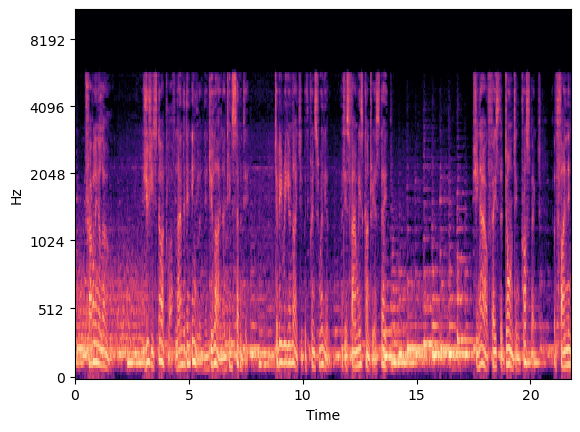

In [12]:
librosa.display.specshow(mel_spect_power, y_axis='mel', x_axis='time')

Mel-frequency cepstral coefficients

In [13]:
mfccs = librosa.feature.mfcc(y = example_audio, sr = target_sr)

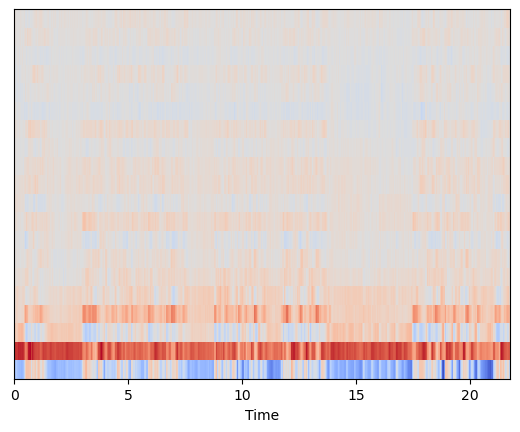

In [14]:
librosa.display.specshow(mfccs, x_axis='time')

Root Mean Square

In [15]:
S, phase = librosa.magphase(librosa.stft(y = example_audio))
rms = librosa.feature.rms(y = example_audio)

[Text(0.5, 1.0, 'log Power spectrogram')]

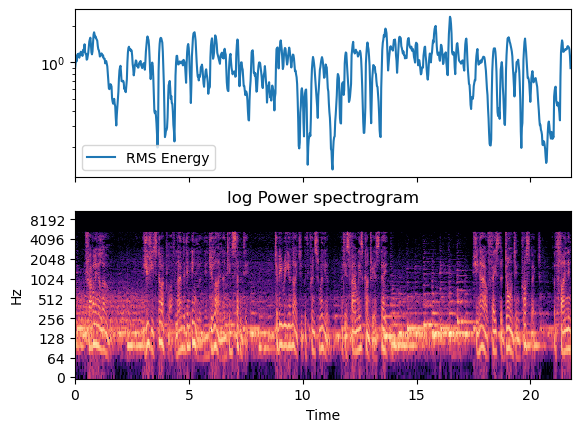

In [16]:
fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(rms)
ax[0].semilogy(times, rms[0], label='RMS Energy')
ax[0].set(xticks=[])
ax[0].legend()
ax[0].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')

Spectral Centroid + Bandwidth

In [17]:
spec_bw = librosa.feature.spectral_bandwidth(y = example_audio, sr = target_sr)
spec_ct = librosa.feature.spectral_centroid(y = example_audio, sr = target_sr)

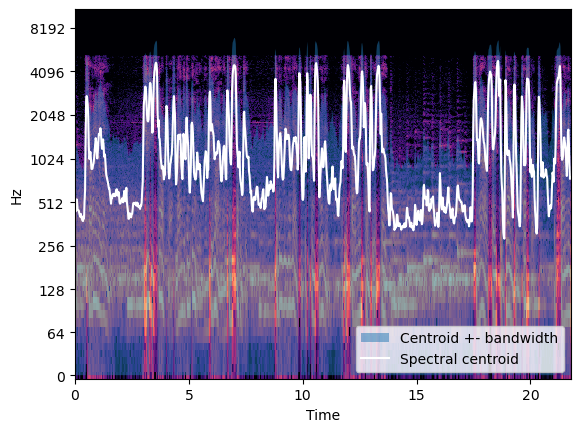

In [18]:
times = librosa.times_like(spec_bw)

librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time')
plt.fill_between(times, np.maximum(0, spec_ct[0] - spec_bw[0]),
                np.minimum(spec_ct[0] + spec_bw[0], target_sr/2),
                alpha=0.5, label='Centroid +- bandwidth')
plt.plot(times, spec_ct[0], label='Spectral centroid', color='w')
plt.legend(loc='lower right')

Spectral Contrast

In [19]:
spec_con = librosa.feature.spectral_contrast(y = example_audio, sr = target_sr)

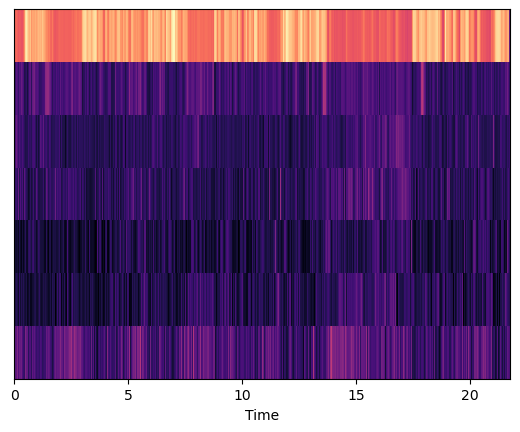

In [20]:
librosa.display.specshow(spec_con, x_axis='time')

### Feature Extraction Example

In [21]:
example_features = pd.DataFrame([feature_extraction(example_audio, target_sr)])
example_features

rms_mean   rms_var  melspectrogram_mean  melspectrogram_var  \
0  0.918106  0.155448           210.483185           2853138.5   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1234.493283           1.032137e+06              1403.791582   

   spectral_bandwidth_var  spectral_contrast_mean  spectral_contrast_var  ...  \
0           345743.107844               24.607756             249.962255  ...   

   mfcc16_mean  mfcc16_var  mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  \
0   -14.569848  -14.569848    -8.156853   -8.156853   -18.000471  -18.000471   

   mfcc19_mean  mfcc19_var  mfcc20_mean  mfcc20_var  
0    -8.656404   -8.656404    -9.244837   -9.244837  

[1 rows x 50 columns]

## Importing -> Preprocessing -> Feature Extraction

In [5]:
def import_process_extract(path, target_sr, limit_to_10k = True):
    frames = []

    lang_len = len(os.listdir(path))
    for lang_index, lang in enumerate(os.listdir(path)):

        audio_len = len(os.listdir(f'{path}/{lang}'))
        for audio_index, audio_file in enumerate(os.listdir(f'{path}/{lang}')):

            #limit importing to 5k 
            if limit_to_10k:
                if (audio_index + 1) > 5000:
                    continue

            print(f'{lang_index + 1}/{lang_len} | {lang} | {audio_index + 1}/{audio_len if not limit_to_10k else 5000}')

            audio_lb, sr = librosa.load(f'{path}/{lang}/{audio_file}', mono = True)

            audio_preprocessed = preprocess_audio(audio_lb, sr, target_sr)

            audio_data = feature_extraction(audio_preprocessed, target_sr)

            audio_data['label'] = lang
            
            frames.append(audio_data)
    
    return pd.DataFrame(frames)

### Loading Datasets
Importing all the audio files one by one. Audio dataset: https://bark.phon.ioc.ee/voxlingua107/
We are limitting dataset sizes for each language for the sake of time and hardware limitations.
| Language | Code Name | Actual Data Size |
|---|---|---|
| English | en | 15860 |
| Arabic | ar |  21645 | 
| Urdu | ur |  13653 | 
| Tagalog | tl | 37718 | 

In [38]:
audio_dataset_path = "audio_datasets"
audio_dataset = import_process_extract(audio_dataset_path, target_sr)

1/4 | ar | 1/5000
1/4 | ar | 2/5000
1/4 | ar | 3/5000
1/4 | ar | 4/5000
1/4 | ar | 5/5000
1/4 | ar | 6/5000
1/4 | ar | 7/5000
1/4 | ar | 8/5000
1/4 | ar | 9/5000
1/4 | ar | 10/5000
1/4 | ar | 11/5000
1/4 | ar | 12/5000
1/4 | ar | 13/5000
1/4 | ar | 14/5000
1/4 | ar | 15/5000
1/4 | ar | 16/5000
1/4 | ar | 17/5000
1/4 | ar | 18/5000
1/4 | ar | 19/5000
1/4 | ar | 20/5000
1/4 | ar | 21/5000
1/4 | ar | 22/5000
1/4 | ar | 23/5000
1/4 | ar | 24/5000
1/4 | ar | 25/5000
1/4 | ar | 26/5000
1/4 | ar | 27/5000
1/4 | ar | 28/5000
1/4 | ar | 29/5000
1/4 | ar | 30/5000
1/4 | ar | 31/5000
1/4 | ar | 32/5000
1/4 | ar | 33/5000
1/4 | ar | 34/5000
1/4 | ar | 35/5000
1/4 | ar | 36/5000
1/4 | ar | 37/5000
1/4 | ar | 38/5000
1/4 | ar | 39/5000
1/4 | ar | 40/5000
1/4 | ar | 41/5000
1/4 | ar | 42/5000
1/4 | ar | 43/5000
1/4 | ar | 44/5000
1/4 | ar | 45/5000
1/4 | ar | 46/5000
1/4 | ar | 47/5000
1/4 | ar | 48/5000
1/4 | ar | 49/5000
1/4 | ar | 50/5000
1/4 | ar | 51/5000
1/4 | ar | 52/5000
1/4 | ar | 53/5000
1/

In [40]:
audio_dataset.to_csv("audio_datasets.csv")

We saved this to a csv file so we longer need to wait for 2 hours to import data.

In [4]:
audio_dataset = pd.read_csv("audio_datasets.csv")

In [5]:
audio_dataset.drop(['Unnamed: 0'], inplace = True, axis = 1)

In [12]:
audio_dataset

rms_mean   rms_var  melspectrogram_mean  melspectrogram_var  \
0      0.826583  0.315582           190.157959         2290700.250   
1      0.812921  0.338134           183.489151         1854305.875   
2      0.830635  0.309512           190.531433         3341085.000   
3      0.826412  0.316885           197.622665         2708140.000   
4      0.814848  0.335793           199.827560         2755490.500   
...         ...       ...                  ...                 ...   
19995  0.813422  0.336611           211.698929         3828962.000   
19996  0.774331  0.398829           212.121933         3185725.250   
19997  0.771640  0.404028           211.826859         3691608.250   
19998  0.835010  0.301815           212.103256         4141871.000   
19999  0.777442  0.394666           212.124786         4711542.500   

       spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                 1763.387891           1.008279e+06              1581.069780   
1                 1970.929350           1.356079e+06              1673.969296   
2                 1841.510976           1.472675e+06              1533.668797   
3                 1627.861499           8.742052e+05              1524.360713   
4                 1695.491159           8.106676e+05              1599.448411   
...                       ...                    ...                      ...   
19995             1106.492239           1.083709e+05              1293.430527   
19996             1074.441177           1.088567e+05              1358.610287   
19997             1154.128333           1.414499e+05              1341.766399   
19998             1282.659998           3.499819e+05              1487.436384   
19999             1162.271221           2.024245e+05              1360.468114   

       spectral_bandwidth_var  spectral_contrast_mean  spectral_contrast_var  \
0               215722.466054               23.953255             282.696019   
1               160434.084097               23.025206             291.544208   
2               192829.555142               23.825372             286.659282   
3               202412.930246               23.239489             277.535655   
4               168569.788597               23.168985             283.853478   
...                       ...                     ...                    ...   
19995           122783.782697               25.498682             277.266913   
19996           144787.367738               24.668985             261.898761   
19997           148303.099333               24.852746             252.432015   
19998           193743.715418               26.110681             283.231524   
19999           174136.760725               25.024149             269.486131   

       ...  mfcc16_var  mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  \
0      ...   -2.636389     0.506726    0.506726    -6.619588   -6.619588   
1      ...   -1.819555    -2.099007   -2.099007    -6.179954   -6.179954   
2      ...   -4.673801    -2.109507   -2.109507    -6.304261   -6.304261   
3      ...   -1.033171    -1.465145   -1.465145    -5.784088   -5.784088   
4      ...    1.049760     0.188508    0.188508    -8.118744   -8.118744   
...    ...         ...          ...         ...          ...         ...   
19995  ...   -6.929118    -4.017136   -4.017136     0.397751    0.397751   
19996  ...   -9.281070    -5.228024   -5.228024    -3.445431   -3.445431   
19997  ...   -6.201410    -2.365206   -2.365206    -3.167490   -3.167490   
19998  ...   -3.688288     0.263914    0.263914    -5.686716   -5.686716   
19999  ...   -2.653435    -0.340152   -0.340152    -2.591531   -2.591531   

       mfcc19_mean  mfcc19_var  mfcc20_mean  mfcc20_var  label  
0        -1.363352   -1.363352    -3.763640   -3.763640     ar  
1         1.757663    1.757663    -7.313949   -7.313949     ar  
2        -0.798857   -0.798857    -6.275505   -6.275505     ar  
3         0.519553    0.519553    -5.081917   -5.081917    

Now let's see how many of each language we have. As expected, we have 5000 of each.

In [13]:
counting = audio_dataset.groupby(["label"]).size().reset_index(name = "Count")
counting

label  Count
0    ar   5000
1    en   5000
2    tl   5000
3    ur   5000

## Processing Data for the Model

Splitting to X and Y

In [6]:
X = audio_dataset.drop(["label"], axis = 1)
Y = audio_dataset["label"]

Splitting to train and test sets of equal label distribution

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=50, stratify=Y)

Scaling the data

In [8]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

Label Encoding Y column for models that need it

In [9]:
from sklearn.preprocessing import LabelEncoder

le_Y = LabelEncoder()
le_Y.fit(["en", "tl", "ar", "ur"])
Y_train_encoded = le_Y.transform(Y_train)
Y_test_encoded = le_Y.transform(Y_test)

## Machine Learning Models

### Random Forest Classifier | sklearn

In [57]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier() 

forest.fit(X_train, Y_train)

RandomForestClassifier()

### C-Support Vector Classification | sklearn

In [24]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, Y_train)

SVC()

### XGBoost / sklearn
https://www.kaggle.com/code/aishwarya2210/let-s-tune-the-music-with-cnn-xgboost

In [58]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, Y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### Keras Sequential Model | tensorflow
https://medium.com/@sdoshi579/classification-of-music-into-different-genres-using-keras-82ab5339efe0

In [59]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, Y_train_encoded, epochs=20, batch_size=128)

Epoch 1/20
125/125 [==============================] - 2s 4ms/step - loss: 0.9756 - accuracy: 0.6234
Epoch 2/20
125/125 [==============================] - 1s 4ms/step - loss: 0.6112 - accuracy: 0.7766
Epoch 3/20
125/125 [==============================] - 1s 4ms/step - loss: 0.4922 - accuracy: 0.8242
Epoch 4/20
125/125 [==============================] - 1s 4ms/step - loss: 0.4162 - accuracy: 0.8538
Epoch 5/20
125/125 [==============================] - 0s 4ms/step - loss: 0.3656 - accuracy: 0.8727
Epoch 6/20
125/125 [==============================] - 1s 4ms/step - loss: 0.3224 - accuracy: 0.8863
Epoch 7/20
125/125 [==============================] - 0s 4ms/step - loss: 0.2845 - accuracy: 0.9017
Epoch 8/20
125/125 [==============================] - 1s 4ms/step - loss: 0.2555 - accuracy: 0.9101
Epoch 9/20
125/125 [==============================] - 1s 4ms/step - loss: 0.2255 - accuracy: 0.9231
Epoch 10/20
125/125 [==============================] - 1s 4ms/step - loss: 0.2031 - accuracy: 0.9298

### Scores of each model

In [60]:
pd.DataFrame({
    'model': ["Random Forest", "SVM", "XGBoost", "Keras Sequential Model"],
    'scores': [forest.score(X_test, Y_test), svc.score(X_test, Y_test), xgb.score(X_test, Y_test_encoded), model.evaluate(X_test, Y_test_encoded)[1]]
})

125/125 [==============================] - 1s 3ms/step - loss: 0.3710 - accuracy: 0.9062


model   scores
0           Random Forest  0.88450
1                     SVM  0.87250
2                 XGBoost  0.88500
3  Keras Sequential Model  0.90625

### Saving the models

In [65]:
import pickle
with open("./models/forest.pkl", "wb") as f: pickle.dump(forest, f)
with open("./models/svc.pkl", "wb") as f: pickle.dump(svc, f)
with open("./models/xgb.pkl", "wb") as f: pickle.dump(xgb, f)
model.save("./models/keras.keras")

## Testing Model with Real Data

Function for getting filenames

In [27]:
def get_filenames_arr(path):
    arr = []
    for lang in os.listdir(path):
        for audio_file in os.listdir(f'{path}/{lang}'):
            arr.append(audio_file.removesuffix(".wav"))
    return arr

test_audio_names = get_filenames_arr('./data_dev_test/')

Importing and processing audio files

In [28]:
testing_audio_data = import_process_extract('./data_dev_test/', target_sr, False)

testing_audio_data_features = testing_audio_data.drop(['label'], axis = 1)

testing_audio_data

1/4 | ar | 1/2
1/4 | ar | 2/2
2/4 | en | 1/2
2/4 | en | 2/2
3/4 | tl | 1/7
3/4 | tl | 2/7
3/4 | tl | 3/7
3/4 | tl | 4/7
3/4 | tl | 5/7
3/4 | tl | 6/7
3/4 | tl | 7/7
4/4 | ur | 1/2
4/4 | ur | 2/2


rms_mean   rms_var  melspectrogram_mean  melspectrogram_var  \
0   0.429356  1.513022           360.816772        6.976753e+07   
1   0.721362  0.479624           213.943741        7.303792e+06   
2   0.915750  0.159630           210.399353        2.945107e+06   
3   0.868017  0.246008           208.461792        2.563810e+06   
4   0.831314  0.307899           208.621872        3.920128e+06   
5   0.763458  0.419427           193.921356        3.971066e+06   
6   0.747374  0.441002           190.876114        2.380557e+06   
7   0.759701  0.426997           203.989990        3.845089e+06   
8   0.801393  0.363997           199.056976        3.164339e+06   
9   0.961416  0.075143           205.599869        2.239766e+06   
10  0.847328  0.281541           201.451279        2.040714e+06   
11  0.715334  0.487411           212.387329        1.050282e+07   
12  0.952448  0.211204           236.978104        3.288620e+06   

    spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0              3614.804798           1.797167e+06              2196.845222   
1              1105.111979           3.040258e+05              1487.635416   
2              1262.423664           1.126751e+06              1413.993462   
3              1609.189927           1.133073e+06              1796.084194   
4              2041.951011           1.344065e+06              2349.632398   
5              1348.552816           1.008808e+06              1771.921578   
6              1144.672159           5.515994e+05              1376.583347   
7              1441.812103           7.243457e+05              1635.052658   
8              1416.120218           4.573452e+05              1414.791375   
9              1133.757745           9.174033e+05              1303.203794   
10             1834.613105           4.758851e+05              1855.424447   
11             1313.448926           7.452140e+05              1491.610743   
12             1299.165750           1.258536e+06              1450.580840   

    spectral_bandwidth_var  spectral_contrast_mean  spectral_contrast_var  \
0            162436.251633               19.201481             173.503026   
1            618195.637398               26.267607             255.809565   
2            340460.069530               24.576340             251.343502   
3            267198.910056               27.186865             256.404073   
4            258387.933669               26.156005             292.633186   
5            401902.850580               23.956508             262.963081   
6            209408.139494               24.790852             221.480713   
7            300766.734445               24.010902             206.997379   
8            101709.386806               23.998777             219.098758   
9            323715.694387               25.132669             270.059707   
10            70599.434960               25.536260             333.468934   
11           167567.303915               23.359430             235.379140   
12           187188.673152               25.691125             284.497691   

    ...  mfcc16_var  mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  \
0   ...   -0.110946     1.250815    1.250815    -1.780396   -1.780396   
1   ...    6.125902     5.651509    5.651509    -1.972992   -1.972992   
2   ...  -13.848403    -7.843161   -7.843161   -17.468588  -17.468588   
3   ...   -7.123361     2.493496    2.493496   -18.005600  -18.005600   
4   ...   -7.792741    -1.525961   -1.525961    -0.317825   -0.317825   
5   ...  -15.421909    10.375080   10.375080     3.078092    3.078092   
6   ...   -0.078850    -0.911075   -0.911075    -1.201366   -1.201366   
7   ...   -4.676712     7.912579    7.912579     2.595987    2.595987   
8   ...   -2.625910    -6.678414   -6.678414    -7.373274   -7.373274   
9   ...   -2.298205     5.107244    5.107244     0.161734    0.161734   
10  ...   -1.455240    -0.138034   -0.138034    -6.558882   -6.558882   
11  ...   -0.3442

In [29]:
testing_audio_data_scaled = ss.transform(testing_audio_data_features)

Checking predictions

In [63]:
f_pred = forest.predict(testing_audio_data_scaled)
svm_pred = svc.predict(testing_audio_data_scaled)
xgb_pred = xgb.predict(testing_audio_data_scaled)
keras_pred = [np.argmax(pred) for pred in model.predict(testing_audio_data_scaled)]

pd.DataFrame({
    "Name": test_audio_names,
    "Actual": testing_audio_data["label"],
    "Forest": f_pred,
    "SVM": svm_pred,
    "XGC": le_Y.inverse_transform(xgb_pred),
    "Keras": le_Y.inverse_transform(keras_pred),
})


1/1 [==============================] - 0s 54ms/step


Name Actual Forest SVM XGC Keras
0           ar     ar     ar  ar  ar    ur
1         omar     ar     ur  ur  ur    ur
2           en     en     ur  ur  ar    en
3          lks     en     en  ar  en    ar
4       denise     tl     ar  ur  en    ur
5      diether     tl     en  ar  en    ar
6   dylan_morn     tl     ar  en  en    ur
7       father     tl     ur  en  en    tl
8       mother     tl     tl  tl  tl    tl
9           rj     tl     en  en  en    ar
10          tl     tl     tl  tl  tl    tl
11        huda     ur     ar  en  en    en
12          ur     ur     ar  ar  ur    ur

# GUI Application

In [11]:
print("Importing Core libraries...")
import tkinter as tk
from tkinter import messagebox
import numpy as np
from time import sleep

print("Importing Audio libraries...")
import sounddevice as sd
import librosa
import soundfile as sf
import pygame

print("Importing Models libraries...")
import pickle
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder

# Global variables
le_Y = LabelEncoder()
le_Y.fit(["en", "tl", "ar", "ur"])
lang_names = {
   "en": "English",
   "tl": "Tagalog",
   "ar": "Arabic",
   "ur": "Urdu"
}
record = False
audio = []
duration = 5 # Duration of recording in seconds
sample_rate = 32000 # Sample rate in Hz

#Load models
print("Importing Models...")
forest_model = pickle.load(open("models/forest.pkl", "rb"))
svc_model = pickle.load(open("models/svc.pkl", "rb"))
xgb_model = pickle.load(open("models/xgb.pkl", "rb"))
keras_model = load_model('models/keras.keras')

def callback(indata, frames, time, status):
  global record, audio
  if record:
      audio.append(indata.copy())

def start_recording():
  global record, audio
  audio = []
  record = True
  stream = sd.InputStream(callback=callback, channels=1, samplerate=sample_rate)
  with stream:
    sd.sleep(duration * 1000)
  record = False
  # Convert list of arrays into single array
  audio = np.concatenate(audio, axis=0)

    # Save audio data to .wav file
  sf.write('output.wav', audio, sample_rate)

  sd.stop()

def play_audio():
  pygame.mixer.init()
  pygame.mixer.music.load('output.wav')
  pygame.mixer.music.play()
  sleep(4.8)
  pygame.mixer.music.unload()
  pygame.mixer.music.stop()

def predict_audio():
  audio_data, sr = librosa.load('output.wav')
  processed_data = preprocess_audio(audio_data, sr, sample_rate)
  processed_data = pd.DataFrame([feature_extraction(processed_data, target_sr)])
  processed_data = ss.transform(processed_data)

  # Make predictions with each model
  forest_pred = forest_model.predict(processed_data)
  svc_pred = svc_model.predict(processed_data)
  xgb_pred = le_Y.inverse_transform(xgb_model.predict(processed_data))
  keras_pred = le_Y.inverse_transform([np.argmax(keras_model.predict(processed_data)[0])])

  print(f"Forest : {forest_pred} | SVC : {svc_pred} | XGBoost : {xgb_pred} | Keras : {keras_pred}")

  # Print predictions
  predictions_arr = np.array([forest_pred, svc_pred, xgb_pred, keras_pred])
  values, counts = np.unique(predictions_arr, return_counts=True)
  actual_pred = values[counts.argmax()]

  prediction.config(text = lang_names[actual_pred] + "!")
  

# ==================== TKINTER ====================
print("Generating GUI...")
root = tk.Tk()

frame = tk.Frame(root)
frame.configure(height=500, width=500)

title = tk.Label(frame)
title.configure(
    font="{Bahnschrift Light} 30 {bold}",
    text='Language Predictor!')
title.place(anchor="center", relx=0.5, rely=0.25)

record = tk.Button(frame)
record.configure(font="{Bahnschrift Light} 16 {}", text='Record', command=start_recording)
record.place(
    anchor="center",
    height=50,
    relx=0.25,
    rely=0.75,
    width=100)

play = tk.Button(frame)
play.configure(
    font="{Bahnschrift Light} 12 {}",
    text='Play Recording',
    command=play_audio,
    wraplength=100)
play.place(
    anchor="center",
    height=50,
    relx=0.5,
    rely=0.75,
    width=100)

predict = tk.Button(frame)
predict.configure(
    font="{Bahnschrift Light} 16 {}",
    text='Predict!',
    command=predict_audio)
predict.place(
    anchor="center",
    height=50,
    relx=0.75,
    rely=0.75,
    width=100)

text = tk.Label(frame)
text.configure(
    font="{Bahnschrift Light} 12 {}",
    takefocus=False,
    text="I think it's...")
text.place(anchor="s", relx=0.5, rely=0.5, x=0, y=-25)

prediction = tk.Label(frame)
prediction.configure(
    font="{Bahnschrift Light} 24 {}",
    text='Something!')
prediction.place(anchor="center", relx=0.5, rely=0.5, x=0, y=0)
frame.pack(side="top")

root.mainloop()

Importing Core libraries...
Importing Audio libraries...
Importing Models libraries...
Importing Models...
Generating GUI...
1/1 [==============================] - 0s 87ms/step
Forest : ['ar'] | SVC : ['ur'] | XGBoost : ['ur'] | Keras : ['ur']
1/1 [==============================] - 0s 31ms/step
Forest : ['ar'] | SVC : ['ur'] | XGBoost : ['ur'] | Keras : ['ur']
1/1 [==============================] - 0s 38ms/step
Forest : ['ar'] | SVC : ['ur'] | XGBoost : ['ar'] | Keras : ['en']
1/1 [==============================] - 0s 40ms/step
Forest : ['ar'] | SVC : ['ur'] | XGBoost : ['ar'] | Keras : ['ur']
